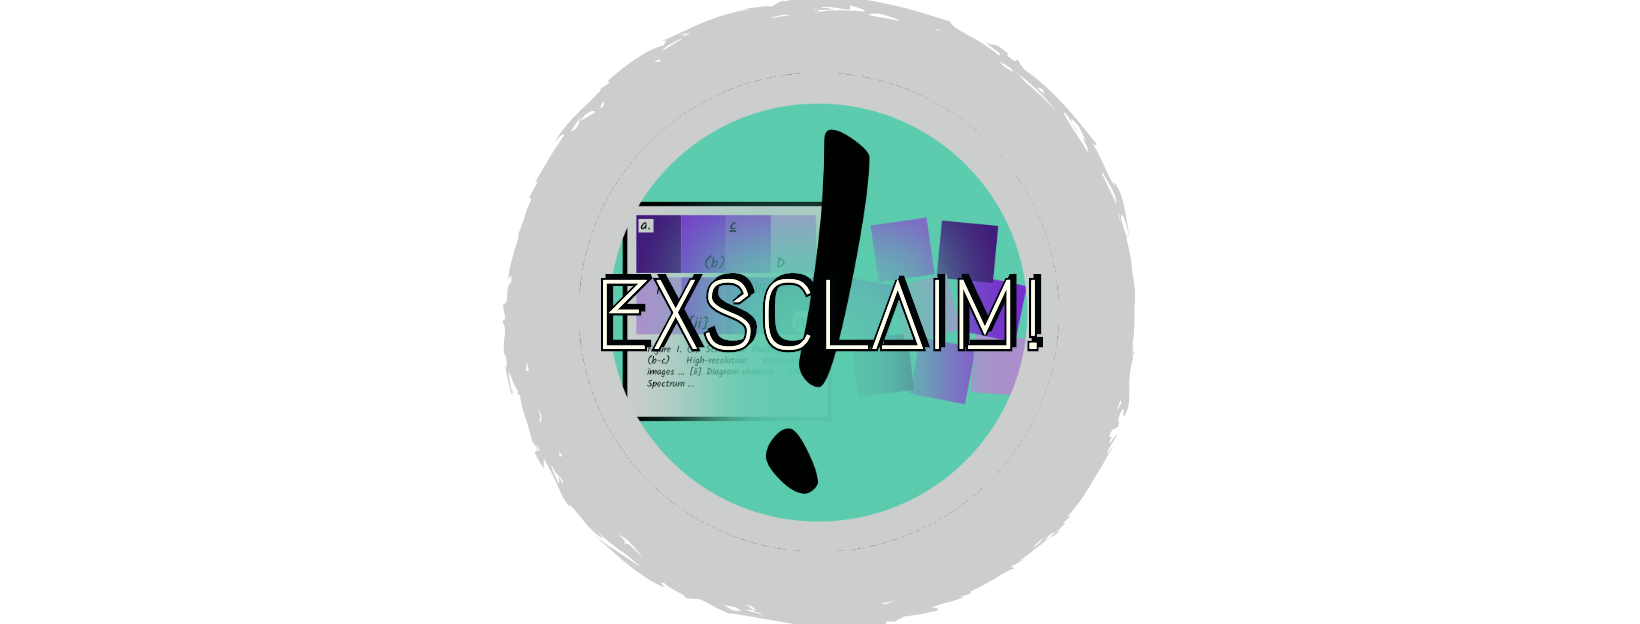

# Install EXSCLAIM! code and dependencies

In [ ]:
!pip install selenium-stealth
!pip install webdriver-manager
!sudo apt install chromium-chromedriver
!sudo add-apt-repository ppa:saiarcot895/chromium-beta
!sudo apt remove chromium-browser
!sudo snap remove chromium
!sudo apt install chromium-browser
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium
from IPython.display import clear_output
clear_output()

In [ ]:
!git clone -b javascript_fixes https://github.com/katerinavr/exsclaim.git  #javascript_fixes
%cd exsclaim
!python setup.py install
!pip install urllib3==1.25.10
!pip install --upgrade --no-cache-dir gdown
from IPython.display import clear_output
clear_output()

In [ ]:
from exsclaim import journal
from exsclaim import pipeline
from exsclaim import tool
import itertools
import json
import logging
import math
import os
import pathlib
import random
import shutil
import time
import urllib.request
from selenium_stealth import stealth
from exsclaim.journal import JournalFamilyDynamic
from bs4 import BeautifulSoup
import requests
from selenium import webdriver

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


# Import the pretrained models

In [ ]:
#import requests
import os

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?id="+id
    cmd = "gdown %s -O %s"%(URL, destination)
    os.system(cmd)  

In [ ]:
# Load the pretrained models
!mkdir /content/exsclaim/exsclaim/figures/checkpoints/
download_file_from_google_drive('1ZodeH37Nd4ZbA0_1G_MkLKuuiyk7VUXR', '/content/exsclaim/exsclaim/figures/checkpoints/classifier_model.pt')
download_file_from_google_drive('1Hh7IPTEc-oTWDGAxI9o0lKrv9MBgP4rm', '/content/exsclaim/exsclaim/figures/checkpoints/object_detection_model.pt')
download_file_from_google_drive('1rZaxCPEWKGwvwYYa8jLINpUt20h0jo8y', '/content/exsclaim/exsclaim/figures/checkpoints/text_recognition_model.pt')
download_file_from_google_drive('1B4_rMbP3a1XguHHX4EnJ6tSlyCCRIiy4', '/content/exsclaim/exsclaim/figures/checkpoints/scale_bar_detection_model.pt')
download_file_from_google_drive('1oGjPG698LdSGvv3FhrLYh_1FhcmYYKpu', '/content/exsclaim/exsclaim/figures/checkpoints/scale_label_recognition_model.pt')

# Setting up your query json file

Below you can find an example of the json query which is the input to the pipeline. Several example queries can be found under: /exsclaim/query

```
# Creating the query json file

 {    "name": "acs-nano",
    "journal_family": "acs",
    "maximum_scraped": 2,
    "sortby": "relevant",
    "query":
    { "search_field_1":
        {   "term":"nano",
            "synonyms":["nanoparticle"] } },
    "open": true,
    "save_format": ["boxes"],
    "logging": ["print", "exsclaim.log"] }

```
*   **name**: the name of the folder to save the files
*   **journal_family**: select among Nature, ACS, RSC, Wiley
*   **maximum_scraped**: define the number of papers to scrap data from 
*   **query**: set the names and synonims of the search
*   **open**: is open access
*   **save format**:
                "boxes" --> draw bounding boxes 
                "visualization" --> save subfigures with their labels 
                "csv" --> save the extracted data in csv
*   **logging**: "print" --> print the events when exsclaim runs






# You can run now run the EXSCLAIM query for scrapping data from Nature, ACS, Wiley, RSC journals

Once the run is completed successfully a **SUCCESS** message will be printed.
Inside the exsclaim directory the generated documents can be located into the /exsclaim/output/name

# Nature journal example



In [ ]:
#@title run the cell

def is_link_to_open_article(self, tag):
        #raise ValueError()
        i = 0
        current_tag = tag
        while current_tag.parent and i < 4:
            current_tag = current_tag.parent
            i += 1
        candidates = current_tag.find_all("span", attrs={'data-test': 'open-access', 'itemprop': "openAccess"})
        return len(candidates)>=1
journal.Nature.is_link_to_open_article = is_link_to_open_article

def get_page_info(self, soup):
  def parse_page(page):
    # Fetches the page number given the string 'page #' (e.g. page 1) otherwise
    # returns None
    info = page.strip().split()
    if len(info) != 2 or info[0] != 'page':
      raise ValueError(f'Info {info} should be of the format "page i"')
    
    return int(info[1])
  
  active_link = soup.find(class_='c-pagination__link c-pagination__link--active')

  try: 
    current_page = parse_page(active_link.text)  
    pages = soup.find_all(class_='c-pagination__item')
    total_pages = parse_page(pages[-2].text)  

  except:
    current_page, total_pages = 1, 1

  if soup.find(attrs={'data-test': 'results-data'}) == None:
    #pass
    raise ValueError(f'No articles were found, try to modily the search criteria')

  try:
    total_results = int(soup.find(attrs={'data-test': 'results-data'}).text.split()[-2])
    return current_page, total_pages, total_results
  except: 
    pass

journal.Nature.get_page_info = get_page_info


import itertools
import re

def get_search_query_urls(self) -> str:
    """
    Create url for a GET request based on the search_query.
    Returns:
        A list of urls (as strings)
    """
    search_query = self.search_query
    ## creates a list of search terms
    search_list = ([[search_query['query'][key]['term']] + 
                  search_query['query'][key]['synonyms'] 
                  for key in search_query['query']])
    

    search_product = list(itertools.product(*search_list))
    
    # sortby is the requested method to sort results (relevancy or recency) and
    # sbtext gives the journal specific parameter to sort as requested
    sortby = search_query['sortby']
    if sortby == 'relevant':
        sbext = self.relevant
    elif sortby == 'recent':
        sbext = self.recent

    # modify search to find only open access articles
    if search_query.get("open", False):
        self.pre_sb = self.open_pre_sb

    search_query_urls = []
    # this creates the url (excluding domain and protocol) for each search query
    for search_group in search_product:
        search_query_url = (self.domain + self.path
            + self.join.join(['+'.join(a.split(' ')) for a in search_group])
            + self.pre_sb + sbext + self.post_sb + '&openAccess=18&accessType=openAccess&')
        search_query_url = search_query_url.replace('"',  "'")
        search_query_urls.append(search_query_url)
    
    print(search_query_urls)
    return search_query_urls


journal.JournalFamily.get_search_query_urls = get_search_query_urls

def to_file(self):
        """ Saves data to a csv and saves subfigures as individual images
        
        Modifies:
            Creates directories to save each subfigure
        """
        search_query = self.query_dict
        self.display_info(
            ("Printing Master Image Objects to: {}/images\n".format(
                self.results_directory
            ))
        )
        for figure_name in self.exsclaim_dict:
            # figure_name is <figure_root_name>.<figure_extension>
            figure_root_name, figure_extension = os.path.splitext(figure_name)
            try:
                figure = plt.imread(
                    self.results_directory / "figures" / figure_name
                )
            except Exception as e:
                self.logger.exception(("Error printing {0} to file."
                    " It may be damaged!".format(figure_name)))
                figure = np.zeros((256,256))

            ## save each master, inset, and dependent image as their own file
            ## in a directory according to label
            figure_dict = self.exsclaim_dict[figure_name]
            for master_image in figure_dict.get("master_images", []):
                # create a directory for each master image in 
                # <results_dir>/images/<figure_name>/<subfigure_label>
                directory = (
                    self.results_directory / "images" / figure_root_name / 
                    master_image['subfigure_label']['text']
                )
                os.makedirs(directory, exist_ok=True)
                # generate the name of the master_image
                master_class  = ('uas' if master_image['classification'] is None 
                                       else master_image['classification'][0:3].lower())
                master_name = "/" + "_".join([figure_root_name,
                                              master_image['subfigure_label']['text'],
                                              master_class
                                            ]) + figure_extension
                # save master image to file
                master_patch = boxes.crop_from_geometry(master_image['geometry'], figure)
                master_patch = master_patch.copy(order='C')
                print('dir', directory)
                try:
                    plt.imsave(str(directory) + master_name, master_patch)  
                except Exception as err:
                    self.logger.exception(("Error in saving cropped master"
                        " image of figure: {}".format(figure_root_name)))
                # Repeat for dependents of the master image to file
                for dependent_id, dependent_image in enumerate(master_image.get("dependent_images", [])):
                    dependent_root_name = "/".join([directory, "dependent"])
                    os.makedirs(dependent_root_name, exist_ok=True)
                    dependent_class  = ('uas' if dependent_image['classification'] is None 
                                              else dependent_image['classification'][0:3].lower())
                    dependent_name = "_".join([master_name.split('par')[0] +
                                              "dep" + str(dependent_id),
                                              dependent_class
                                              ]) + figure_extension
                    # save dependent image to file
                    dpatch = boxes.crop_from_geometry(dependent_image['geometry'], figure)
                    try:
                        plt.imsave(dependent_root_name+dependent_name,dpatch) 
                    except Exception as err:
                        self.logger.exception(("Error in saving cropped master"
                            " image of figure: {}".format(figure_root_name)))
                    # Repeat for insets of dependents of master image to file
                    for inset_id, inset_image in enumerate(dependent_image.get("inset_images", [])):
                        inset_root_name = "/".join([dependent_root_name,"inset"])
                        os.makedirs(inset_root_name, exist_ok=True)
                        inset_classification  = ('uas' if inset_image['classification'] is None
                                                 else inset_image['classification'][0:3].lower())
                        inset_name = "_".join([dependent_name.split(figure_extension)[0][0:-3] +
                                               "ins" + str(inset_id),
                                               inset_classification]) + figure_extension
                        
                        ipatch = boxes.crop_from_geometry(inset_image['geometry'],figure)
                        # save inset image to file
                        try:
                            plt.imsave(inset_root_name+inset_name,ipatch)
                        except Exception as err:
                            self.logger.exception(("Error in saving cropped master"
                                " image of figure: {}".format(figure_root_name)))
                # Write insets of masters to file
                for inset_id, inset_image in enumerate(master_image.get("inset_images", [])):
                    inset_root_name = "/".join([directory,"inset"])
                    os.makedirs(inset_root_name, exist_ok=True)
                    inset_classification  = ('uas' if inset_image['classification'] is None
                                              else inset_image['classification'][0:3].lower())
                    inset_name = "_".join([master_name.split(figure_extension)[0][0:-3] +
                                           "ins" + str(inset_id),
                                           inset_classification]) + figure_extension
                    ipatch = boxes.crop_from_geometry(inset_image['geometry'], figure)
                    # save inset image to file
                    try:
                        plt.imsave(inset_root_name+inset_name,ipatch)
                    except Exception as err:
                        self.logger.exception(("Error in saving cropped master"
                            " image of figure: {}".format(figure_root_name)))
        self.display_info(">>> SUCCESS!\n")
pipeline.Pipeline.to_file = to_file

In [ ]:
from exsclaim.pipeline import Pipeline
test_pipeline = Pipeline('/content/exsclaim/query/nature-nano.json')
results = test_pipeline.run()


        @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
        @@@@@@@@@@@@@@@@@@@&   /&@@@(   /@@@@@@@@@@@@@@@@@@@
        @@@@@@@@@@@@@@@ %@@@@@@@@@@@@@@@@@@@ *@@@@@@@@@@@@@@
        @@@@@@@@@@@@ @@@@@@@@@@@@@@,  .@@@@@@@@ *@@@@@@@@@@@
        @@@@@@@@@.#@@@@@@@@@@@@@@@@,    @@@@@@@@@@ @@@@@@@@@
        @@@@@@@&,@@@@@@@@@@@@@@@@@@.    @@@@@@@@@@@@ @@@@@@@
        @@@@@@ @@@@@@@@@@@@@@@@@@@@     @@@@@@@@@@@@@ @@@@@@
        @@@@@ @@@@@@@@@@@@@@@@@@@@@    *@@@@@@@@@@@@@@/@@@@@
        @@@@ @@@@@@@@@@@@@@@@@@@@@@    @@@@@@@@@@@@@@@@,@@@@
        @@@ @@@@@@@@@@@@@@@@@@@@@@&    @@@@@@@@@@@@@@@@@ @@@
        @@@,@@@@@@@@@@@@@@@@@@@@@@*   (@@@@@@@@@@@@@@@@@@%@@
        @@.@@@@@@@@@@@@@@@@@@@@@@@    @@@@@@@@@@@@@@@@@@@ @@
        @@ @@@@@@@@@@@@@@@@@@@@@@@    @@@@@@@@@@@@@@@@@@@ @@
        @@ @@@@@@@@@@@@@@@@@@@@@@/   &@@@@@@@@@@@@@@@@@@@ @@
        @@,@@@@@@@@@@@@@@@@@@@@@@    @@@@@@@@@@@@@@@@@@@@ @@
        @@@.@@@@@@@@@@@@@@@@@@@@&   @@@@@@@@@@@@@@@@@@@@@%@@
        @@@ @@@@@@@@@@@

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Running Journal Scraper
>>> Time Elapsed: 29.04 sec (2 articles)
Running Caption Distributor
>>> Time Elapsed: 38.37 sec (14 captions)
Running Figure Separator
>>> (1 of 14) Extracting images from: /content/exsclaim/output/nature-nano/figures/s41467-022-35773-6_fig1.jpg/content/exsclaim/output/nature-nano/figures/s41467-022-35773-6_fig1.jpg
>>> (2 of 14) Extracting images from: /content/exsclaim/output/nature-nano/figures/s41467-022-35773-6_fig2.jpg/content/exsclaim/output/nature-nano/figures/s41467-022-35773-6_fig2.jpg
>>> (3 of 14) Extracting images from: /content/exsclaim/output/nature-nano/figures/s41467-022-35773-6_fig3.jpg/content/exsclaim/output/nature-nano/figures/s41467-022-35773-6_fig3.jpg
>>> (4 of 14) Extracting images from: /content/exsclaim/output/nature-nano/figures/s41467-022-35773-6_fig4.jpg/content/exsclaim/output/nature-nano/figures/s41467-022-35773-6_fig4.jpg
>>> (5 of 14) Extracting images from: /content/exsclaim/output/nature-nano/figures/s41467-022-35773-6_fig5.j

# RSC journal example

In [ ]:
#@title run the cell
def get_page_info(self, url):  
  options = webdriver.ChromeOptions()
  options.add_argument("start-maximized")  
  options.add_experimental_option("excludeSwitches", ["enable-automation"])
  options.add_experimental_option('useAutomationExtension', False)
  options.add_argument('--headless')
  options.add_argument('--no-sandbox')
  options.add_argument('--disable-dev-shm-usage')
  options.add_argument('--no-sandbox') 
  driver = webdriver.Chrome('chromedriver', options=options)
  stealth(driver,
        languages=["en-US", "en"],
        vendor="Google Inc.",
        platform="Win32",
        webgl_vendor="Intel Inc.",
        renderer="Intel Iris OpenGL Engine",
        fix_hairline=True,
        )
  driver.get(url)
  time.sleep(2)
  soup = BeautifulSoup(driver.page_source, 'html.parser')
  possible_entries = [a.strip("\n") for a in soup.find(class_="fixpadv--l pos--left pagination-summary").text.strip().split(" ") if a.strip("\n").isdigit()]
  driver.close()
  totalPages = possible_entries[-1]
  totalResults = possible_entries[0]
  page = possible_entries[1]
  return int(page), int(totalPages), int(totalResults)

journal.RSC.get_page_info = get_page_info

In [ ]:
from exsclaim.pipeline import Pipeline
test_pipeline = Pipeline('/content/exsclaim/query/rsc-nano.json')
results = test_pipeline.run()


        @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
        @@@@@@@@@@@@@@@@@@@&   /&@@@(   /@@@@@@@@@@@@@@@@@@@
        @@@@@@@@@@@@@@@ %@@@@@@@@@@@@@@@@@@@ *@@@@@@@@@@@@@@
        @@@@@@@@@@@@ @@@@@@@@@@@@@@,  .@@@@@@@@ *@@@@@@@@@@@
        @@@@@@@@@.#@@@@@@@@@@@@@@@@,    @@@@@@@@@@ @@@@@@@@@
        @@@@@@@&,@@@@@@@@@@@@@@@@@@.    @@@@@@@@@@@@ @@@@@@@
        @@@@@@ @@@@@@@@@@@@@@@@@@@@     @@@@@@@@@@@@@ @@@@@@
        @@@@@ @@@@@@@@@@@@@@@@@@@@@    *@@@@@@@@@@@@@@/@@@@@
        @@@@ @@@@@@@@@@@@@@@@@@@@@@    @@@@@@@@@@@@@@@@,@@@@
        @@@ @@@@@@@@@@@@@@@@@@@@@@&    @@@@@@@@@@@@@@@@@ @@@
        @@@,@@@@@@@@@@@@@@@@@@@@@@*   (@@@@@@@@@@@@@@@@@@%@@
        @@.@@@@@@@@@@@@@@@@@@@@@@@    @@@@@@@@@@@@@@@@@@@ @@
        @@ @@@@@@@@@@@@@@@@@@@@@@@    @@@@@@@@@@@@@@@@@@@ @@
        @@ @@@@@@@@@@@@@@@@@@@@@@/   &@@@@@@@@@@@@@@@@@@@ @@
        @@,@@@@@@@@@@@@@@@@@@@@@@    @@@@@@@@@@@@@@@@@@@@ @@
        @@@.@@@@@@@@@@@@@@@@@@@@&   @@@@@@@@@@@@@@@@@@@@@%@@
        @@@ @@@@@@@@@@@

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Running Journal Scraper
search_url https://pubs.rsc.org/en/results?searchtext=nano&PageSize=1000&ArticleAccess=Open+Access&
search url ['https://pubs.rsc.org/en/results?searchtext=nano&PageSize=1000&ArticleAccess=Open+Access&DateRange=&Journal=&SortBy=']
search_url https://pubs.rsc.org/en/results?searchtext=nanoparticle&PageSize=1000&ArticleAccess=Open+Access&
search url ['https://pubs.rsc.org/en/results?searchtext=nano&PageSize=1000&ArticleAccess=Open+Access&DateRange=&Journal=&SortBy=', 'https://pubs.rsc.org/en/results?searchtext=nanoparticle&PageSize=1000&ArticleAccess=Open+Access&DateRange=&Journal=&SortBy=']
search url https://pubs.rsc.org/en/results?searchtext=nano&PageSize=1000&ArticleAccess=Open+Access&DateRange=&Journal=&SortBy=
>>> (1 of 2) Extracting figures from: d0cs01501ffig_name d0cs01501f_fig1.jpg
im_url https://pubs.rsc.org/image/article/2021/CS/d0cs01501f/d0cs01501f-f1.gif
fig_name d0cs01501f_fig2.jpg
im_url https://pubs.rsc.org/image/article/2021/CS/d0cs01501f/d0cs01

# ACS journal example



In [ ]:
#@title run the cell
def get_page_info(self, url):
        options = webdriver.ChromeOptions()
        options.add_argument("start-maximized")  
        options.add_experimental_option("excludeSwitches", ["enable-automation"])
        options.add_experimental_option('useAutomationExtension', False)
        options.add_argument('--headless')
        options.add_argument('--no-sandbox')
        options.add_argument('--disable-dev-shm-usage')
        options.add_argument('--no-sandbox') 
        driver = webdriver.Chrome('chromedriver', options=options)
        stealth(driver,
              languages=["en-US", "en"],
              vendor="Google Inc.",
              platform="Win32",
              webgl_vendor="Intel Inc.",
              renderer="Intel Iris OpenGL Engine",
              fix_hairline=True,
              )

        driver.get(url)
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        
        total_results = int(soup.find(class_='result__count').text) 
        if total_results > 2020:
            total_results = 2020

        page_counter_list=[]
        page_counter = soup.find(class_='pagination')
        for page_number in page_counter.find_all('li'):
            page_counter_list.append(page_number.text.strip())
        current_page = int(page_counter_list[0])
        total_pages = total_results // 20
        #print('get page info' , current_page, total_pages, total_results)
        return current_page, total_pages, total_results
journal.ACS.get_page_info = get_page_info

def get_figure_list(self, url):
    """
    Returns list of figures in the givin url
    Args:
        url: a string, the url to be searched
    Returns:
        A list of all figures in the article as BeaustifulSoup Tag objects
    """

    options = webdriver.ChromeOptions()
    options.add_argument("start-maximized")  
    options.add_experimental_option("excludeSwitches", ["enable-automation"])
    options.add_experimental_option('useAutomationExtension', False)
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    options.add_argument('--no-sandbox') 
    driver = webdriver.Chrome('chromedriver', options=options)
    stealth(driver,
          languages=["en-US", "en"],
          vendor="Google Inc.",
          platform="Win32",
          webgl_vendor="Intel Inc.",
          renderer="Intel Iris OpenGL Engine",
          fix_hairline=True,
          )
    driver.get(url)
    time.sleep(2)
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    #soup = BeautifulSoup(self.driver.page_source, 'html.parser')
    #print(soup.find_all('figure'))
    figure_list = [a for a in soup.find_all('figure') if str(a).find(self.extra_key)>-1]
    return figure_list
journal.JournalFamilyDynamic.get_figure_list = get_figure_list

def get_articles_from_search_url(self, search_url: str) -> list:
        """Generates a list of articles from a single search term"""
        max_scraped = self.search_query["maximum_scraped"]
        self.logger.info("GET request: {}".format(search_url))

        options = webdriver.ChromeOptions()
        options.add_argument("start-maximized")  
        options.add_experimental_option("excludeSwitches", ["enable-automation"])
        options.add_experimental_option('useAutomationExtension', False)
        options.add_argument('--headless')
        options.add_argument('--no-sandbox')
        options.add_argument('--disable-dev-shm-usage')
        options.add_argument('--no-sandbox') 
        driver = webdriver.Chrome('chromedriver', options=options)
        stealth(driver,
              languages=["en-US", "en"],
              vendor="Google Inc.",
              platform="Win32",
              webgl_vendor="Intel Inc.",
              renderer="Intel Iris OpenGL Engine",
              fix_hairline=True,
              )

        driver.get(search_url)
        time.sleep(2)
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        #print(soup)
        start_page, stop_page, total_articles = self.get_page_info(search_url)
        article_paths = set()
        for page_number in range(start_page, stop_page + 1):

            for tag in soup.find_all("a", href=True):
                #print('tag', tag)
                #url = tag.attrs['href']
                url = tag.attrs['href']
                #url = url.split('?page=search')[0]
                #raise NameError(
                #"journal family {0} is not defined"
                #)
                #print('url', url)
                if url.split("/")[-1] in self.articles_visited or (
                    self.open and not self.is_link_to_open_article(tag)
                ):
                    # It is an article but we are not interested
                    continue
                if url.startswith('/doi/full/') == True:
                    article_paths.add(url)
                if url.startswith('/en/content/articlehtml/') == True:
                    article_paths.add(url)
                if len(article_paths) >= max_scraped:
                    return article_paths
            # Get next page at end of loop since page 1 is obtained from
            # search_url
            search_url = self.turn_page(search_url, page_number + 1)
        return article_paths
journal.ACS.get_articles_from_search_url = get_articles_from_search_url


def get_article_figures(self, url: str) -> dict:
        """
        Get all figures from an article 
        Args:
            url: A url to a journal article
        Returns:
            A dict of figure_jsons from an article
        """
        options = webdriver.ChromeOptions()
        options.add_argument("start-maximized")  
        options.add_experimental_option("excludeSwitches", ["enable-automation"])
        options.add_experimental_option('useAutomationExtension', False)
        options.add_argument('--headless')
        options.add_argument('--no-sandbox')
        options.add_argument('--disable-dev-shm-usage')
        options.add_argument('--no-sandbox') 
        driver = webdriver.Chrome('chromedriver', options=options)
        stealth(driver,
              languages=["en-US", "en"],
              vendor="Google Inc.",
              platform="Win32",
              webgl_vendor="Intel Inc.",
              renderer="Intel Iris OpenGL Engine",
              fix_hairline=True,
              )
        driver.get(url)
        time.sleep(2)
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        is_open, license = self.get_license(soup)

        html_directory = self.results_directory / "html"
        os.makedirs(html_directory, exist_ok=True)
        with open(html_directory / (url.split("/")[-1]+'.html'), "w", encoding='utf-8') as file:
            file.write(str(soup))

        figure_list = self.get_figure_list(url)
        #raise NameError(
        #        "journal family {0} is not defined"
        #    )
        print('url', url)
        print('figure list',figure_list)
        figures = 1
        article_json = {}

        # for figure in soup.find_all('figure'):
        for figure in figure_list:
            captions = self.find_captions(figure)

            # acs captions are duplicated, one version with no captions
            if len(captions) == 0:
                continue

            # initialize the figure's json
            article_name = url.split("/")[-1]
            figure_json = {"title": soup.find('title').get_text(), 
                            "article_url" : url,
                            "article_name" : article_name}

            # get figure caption
            figure_caption = ""
            for caption in captions:
                figure_caption += caption.get_text()
            figure_json["full_caption"] = figure_caption

            # Allocate entry for caption delimiter
            figure_json["caption_delimiter"] = ""

            # get figure url and name
            if 'rsc' in url.split("."):
                # for image_tag in figure.find_all("a", href=True):
                for image_tag in [a for a in figure.find_all("a", href=True) if str(a).find(self.extra_key)>-1]:
                    image_url = image_tag['href']
            else:
                image_tag = figure.find('img')
                image_url = image_tag.get('src')

            image_url = self.prepend + image_url.replace('_hi-res','')
            if ":" not in image_url:
                image_url = "https:" + image_url
            figure_name = article_name + "_fig" + str(figures) + ".jpg"  #" +  image_url.split('.')[-1]
            print('fig_name',figure_name)
            print('im_url',image_url)
            # save image info
            figure_json["figure_name"] = figure_name
            figure_json["image_url"] = image_url
            figure_json["license"] = license
            figure_json["open"] = is_open

            # save figure as image
            self.save_figure(figure_name, image_url)
            figure_path = (
                pathlib.Path(self.search_query["name"]) / "figures" / figure_name
            )
            figure_json["figure_path"] = str(figure_path)
            figure_json["master_images"] = []
            figure_json["unassigned"] = {
                'master_images': [],
                'dependent_images': [],
                'inset_images': [],
                'subfigure_labels': [],
                'scale_bar_labels':[],
                'scale_bar_lines': [],
                'captions': []
            }
            # add all results
            article_json[figure_name] = figure_json
            # increment index
            figures += 1
        return article_json
journal.JournalFamilyDynamic.get_article_figures = get_article_figures

In [ ]:
from exsclaim.pipeline import Pipeline
test_pipeline = Pipeline('/content/exsclaim/query/acs-nanoparticles.json')
results = test_pipeline.run()


        @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
        @@@@@@@@@@@@@@@@@@@&   /&@@@(   /@@@@@@@@@@@@@@@@@@@
        @@@@@@@@@@@@@@@ %@@@@@@@@@@@@@@@@@@@ *@@@@@@@@@@@@@@
        @@@@@@@@@@@@ @@@@@@@@@@@@@@,  .@@@@@@@@ *@@@@@@@@@@@
        @@@@@@@@@.#@@@@@@@@@@@@@@@@,    @@@@@@@@@@ @@@@@@@@@
        @@@@@@@&,@@@@@@@@@@@@@@@@@@.    @@@@@@@@@@@@ @@@@@@@
        @@@@@@ @@@@@@@@@@@@@@@@@@@@     @@@@@@@@@@@@@ @@@@@@
        @@@@@ @@@@@@@@@@@@@@@@@@@@@    *@@@@@@@@@@@@@@/@@@@@
        @@@@ @@@@@@@@@@@@@@@@@@@@@@    @@@@@@@@@@@@@@@@,@@@@
        @@@ @@@@@@@@@@@@@@@@@@@@@@&    @@@@@@@@@@@@@@@@@ @@@
        @@@,@@@@@@@@@@@@@@@@@@@@@@*   (@@@@@@@@@@@@@@@@@@%@@
        @@.@@@@@@@@@@@@@@@@@@@@@@@    @@@@@@@@@@@@@@@@@@@ @@
        @@ @@@@@@@@@@@@@@@@@@@@@@@    @@@@@@@@@@@@@@@@@@@ @@
        @@ @@@@@@@@@@@@@@@@@@@@@@/   &@@@@@@@@@@@@@@@@@@@ @@
        @@,@@@@@@@@@@@@@@@@@@@@@@    @@@@@@@@@@@@@@@@@@@@ @@
        @@@.@@@@@@@@@@@@@@@@@@@@&   @@@@@@@@@@@@@@@@@@@@@%@@
        @@@ @@@@@@@@@@@

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Running Journal Scraper
search_url https://pubs.acs.org/action/doSearch?AllField=nano&pageSize=100&openAccess=18&accessType=openAccess&
search url ['https://pubs.acs.org/action/doSearch?AllField=nano&pageSize=100&openAccess=18&accessType=openAccess&Earliest=&SeriesKey=&sortBy=']
search_url https://pubs.acs.org/action/doSearch?AllField=nanoparticle&pageSize=100&openAccess=18&accessType=openAccess&
search url ['https://pubs.acs.org/action/doSearch?AllField=nano&pageSize=100&openAccess=18&accessType=openAccess&Earliest=&SeriesKey=&sortBy=', 'https://pubs.acs.org/action/doSearch?AllField=nanoparticle&pageSize=100&openAccess=18&accessType=openAccess&Earliest=&SeriesKey=&sortBy=']
>>> (1 of 2) Extracting figures from: acssensors.9b00644fig_name acssensors.9b00644_fig1.jpg
im_url https://pubs.acs.org/cms/10.1021/acssensors.9b00644/asset/images/medium/se-2019-00644u_0006.gif
fig_name acssensors.9b00644_fig2.jpg
im_url https://pubs.acs.org/cms/10.1021/acssensors.9b00644/asset/images/medium/se-2

ERROR:exsclaim.figure:<!> ERROR: An exception occurred in FigureSeparator on figure: /content/exsclaim/output/acs-nanoparticles/figures/acssensors.9b00644_fig1.jpg
Traceback (most recent call last):
  File "/content/exsclaim/exsclaim/figure.py", line 186, in run
    self.extract_image_objects(figure_path)
  File "/content/exsclaim/exsclaim/figure.py", line 791, in extract_image_objects
    subfigure_info = self.detect_subfigure_boundaries(full_figure_path)
  File "/content/exsclaim/exsclaim/figure.py", line 246, in detect_subfigure_boundaries
    img = io.imread(figure_path)
  File "/usr/local/lib/python3.8/dist-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.8/dist-packages/skimage/io/manage_plugins.py", line 207, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/imageio_plugin.py", line 10, in imread
    return np.asarray

<!> ERROR: An exception occurred in FigureSeparator on figure: /content/exsclaim/output/acs-nanoparticles/figures/acssensors.9b00644_fig2.jpg

ERROR:exsclaim.figure:<!> ERROR: An exception occurred in FigureSeparator on figure: /content/exsclaim/output/acs-nanoparticles/figures/acssensors.9b00644_fig2.jpg
Traceback (most recent call last):
  File "/content/exsclaim/exsclaim/figure.py", line 186, in run
    self.extract_image_objects(figure_path)
  File "/content/exsclaim/exsclaim/figure.py", line 791, in extract_image_objects
    subfigure_info = self.detect_subfigure_boundaries(full_figure_path)
  File "/content/exsclaim/exsclaim/figure.py", line 246, in detect_subfigure_boundaries
    img = io.imread(figure_path)
  File "/usr/local/lib/python3.8/dist-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.8/dist-packages/skimage/io/manage_plugins.py", line 207, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/imageio_plugin.py", line 10, in imread
    return np.asarray

<!> ERROR: An exception occurred in FigureSeparator on figure: /content/exsclaim/output/acs-nanoparticles/figures/acssensors.9b00644_fig3.jpg

ERROR:exsclaim.figure:<!> ERROR: An exception occurred in FigureSeparator on figure: /content/exsclaim/output/acs-nanoparticles/figures/acssensors.9b00644_fig3.jpg
Traceback (most recent call last):
  File "/content/exsclaim/exsclaim/figure.py", line 186, in run
    self.extract_image_objects(figure_path)
  File "/content/exsclaim/exsclaim/figure.py", line 791, in extract_image_objects
    subfigure_info = self.detect_subfigure_boundaries(full_figure_path)
  File "/content/exsclaim/exsclaim/figure.py", line 246, in detect_subfigure_boundaries
    img = io.imread(figure_path)
  File "/usr/local/lib/python3.8/dist-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.8/dist-packages/skimage/io/manage_plugins.py", line 207, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/imageio_plugin.py", line 10, in imread
    return np.asarray

<!> ERROR: An exception occurred in FigureSeparator on figure: /content/exsclaim/output/acs-nanoparticles/figures/acssensors.9b00644_fig4.jpg

ERROR:exsclaim.figure:<!> ERROR: An exception occurred in FigureSeparator on figure: /content/exsclaim/output/acs-nanoparticles/figures/acssensors.9b00644_fig4.jpg
Traceback (most recent call last):
  File "/content/exsclaim/exsclaim/figure.py", line 186, in run
    self.extract_image_objects(figure_path)
  File "/content/exsclaim/exsclaim/figure.py", line 791, in extract_image_objects
    subfigure_info = self.detect_subfigure_boundaries(full_figure_path)
  File "/content/exsclaim/exsclaim/figure.py", line 246, in detect_subfigure_boundaries
    img = io.imread(figure_path)
  File "/usr/local/lib/python3.8/dist-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.8/dist-packages/skimage/io/manage_plugins.py", line 207, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/imageio_plugin.py", line 10, in imread
    return np.asarray

<!> ERROR: An exception occurred in FigureSeparator on figure: /content/exsclaim/output/acs-nanoparticles/figures/acssensors.9b00644_fig5.jpg

ERROR:exsclaim.figure:<!> ERROR: An exception occurred in FigureSeparator on figure: /content/exsclaim/output/acs-nanoparticles/figures/acssensors.9b00644_fig5.jpg
Traceback (most recent call last):
  File "/content/exsclaim/exsclaim/figure.py", line 186, in run
    self.extract_image_objects(figure_path)
  File "/content/exsclaim/exsclaim/figure.py", line 791, in extract_image_objects
    subfigure_info = self.detect_subfigure_boundaries(full_figure_path)
  File "/content/exsclaim/exsclaim/figure.py", line 246, in detect_subfigure_boundaries
    img = io.imread(figure_path)
  File "/usr/local/lib/python3.8/dist-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.8/dist-packages/skimage/io/manage_plugins.py", line 207, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/imageio_plugin.py", line 10, in imread
    return np.asarray

<!> ERROR: An exception occurred in FigureSeparator on figure: /content/exsclaim/output/acs-nanoparticles/figures/acssensors.9b00644_fig6.jpg

ERROR:exsclaim.figure:<!> ERROR: An exception occurred in FigureSeparator on figure: /content/exsclaim/output/acs-nanoparticles/figures/acssensors.9b00644_fig6.jpg
Traceback (most recent call last):
  File "/content/exsclaim/exsclaim/figure.py", line 186, in run
    self.extract_image_objects(figure_path)
  File "/content/exsclaim/exsclaim/figure.py", line 791, in extract_image_objects
    subfigure_info = self.detect_subfigure_boundaries(full_figure_path)
  File "/content/exsclaim/exsclaim/figure.py", line 246, in detect_subfigure_boundaries
    img = io.imread(figure_path)
  File "/usr/local/lib/python3.8/dist-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.8/dist-packages/skimage/io/manage_plugins.py", line 207, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/imageio_plugin.py", line 10, in imread
    return np.asarray

<!> ERROR: An exception occurred in FigureSeparator on figure: /content/exsclaim/output/acs-nanoparticles/figures/jacsau.2c00333_fig1.jpg

ERROR:exsclaim.figure:<!> ERROR: An exception occurred in FigureSeparator on figure: /content/exsclaim/output/acs-nanoparticles/figures/jacsau.2c00333_fig1.jpg
Traceback (most recent call last):
  File "/content/exsclaim/exsclaim/figure.py", line 186, in run
    self.extract_image_objects(figure_path)
  File "/content/exsclaim/exsclaim/figure.py", line 791, in extract_image_objects
    subfigure_info = self.detect_subfigure_boundaries(full_figure_path)
  File "/content/exsclaim/exsclaim/figure.py", line 246, in detect_subfigure_boundaries
    img = io.imread(figure_path)
  File "/usr/local/lib/python3.8/dist-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.8/dist-packages/skimage/io/manage_plugins.py", line 207, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/imageio_plugin.py", line 10, in imread
    return np.asarray(ima

<!> ERROR: An exception occurred in FigureSeparator on figure: /content/exsclaim/output/acs-nanoparticles/figures/jacsau.2c00333_fig2.jpg

ERROR:exsclaim.figure:<!> ERROR: An exception occurred in FigureSeparator on figure: /content/exsclaim/output/acs-nanoparticles/figures/jacsau.2c00333_fig2.jpg
Traceback (most recent call last):
  File "/content/exsclaim/exsclaim/figure.py", line 186, in run
    self.extract_image_objects(figure_path)
  File "/content/exsclaim/exsclaim/figure.py", line 791, in extract_image_objects
    subfigure_info = self.detect_subfigure_boundaries(full_figure_path)
  File "/content/exsclaim/exsclaim/figure.py", line 246, in detect_subfigure_boundaries
    img = io.imread(figure_path)
  File "/usr/local/lib/python3.8/dist-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.8/dist-packages/skimage/io/manage_plugins.py", line 207, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/imageio_plugin.py", line 10, in imread
    return np.asarray(ima

<!> ERROR: An exception occurred in FigureSeparator on figure: /content/exsclaim/output/acs-nanoparticles/figures/jacsau.2c00333_fig3.jpg

ERROR:exsclaim.figure:<!> ERROR: An exception occurred in FigureSeparator on figure: /content/exsclaim/output/acs-nanoparticles/figures/jacsau.2c00333_fig3.jpg
Traceback (most recent call last):
  File "/content/exsclaim/exsclaim/figure.py", line 186, in run
    self.extract_image_objects(figure_path)
  File "/content/exsclaim/exsclaim/figure.py", line 791, in extract_image_objects
    subfigure_info = self.detect_subfigure_boundaries(full_figure_path)
  File "/content/exsclaim/exsclaim/figure.py", line 246, in detect_subfigure_boundaries
    img = io.imread(figure_path)
  File "/usr/local/lib/python3.8/dist-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.8/dist-packages/skimage/io/manage_plugins.py", line 207, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/imageio_plugin.py", line 10, in imread
    return np.asarray(ima

<!> ERROR: An exception occurred in FigureSeparator on figure: /content/exsclaim/output/acs-nanoparticles/figures/jacsau.2c00333_fig4.jpg

ERROR:exsclaim.figure:<!> ERROR: An exception occurred in FigureSeparator on figure: /content/exsclaim/output/acs-nanoparticles/figures/jacsau.2c00333_fig4.jpg
Traceback (most recent call last):
  File "/content/exsclaim/exsclaim/figure.py", line 186, in run
    self.extract_image_objects(figure_path)
  File "/content/exsclaim/exsclaim/figure.py", line 791, in extract_image_objects
    subfigure_info = self.detect_subfigure_boundaries(full_figure_path)
  File "/content/exsclaim/exsclaim/figure.py", line 246, in detect_subfigure_boundaries
    img = io.imread(figure_path)
  File "/usr/local/lib/python3.8/dist-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.8/dist-packages/skimage/io/manage_plugins.py", line 207, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/imageio_plugin.py", line 10, in imread
    return np.asarray(ima

<!> ERROR: An exception occurred in FigureSeparator on figure: /content/exsclaim/output/acs-nanoparticles/figures/jacsau.2c00333_fig5.jpg

ERROR:exsclaim.figure:<!> ERROR: An exception occurred in FigureSeparator on figure: /content/exsclaim/output/acs-nanoparticles/figures/jacsau.2c00333_fig5.jpg
Traceback (most recent call last):
  File "/content/exsclaim/exsclaim/figure.py", line 186, in run
    self.extract_image_objects(figure_path)
  File "/content/exsclaim/exsclaim/figure.py", line 791, in extract_image_objects
    subfigure_info = self.detect_subfigure_boundaries(full_figure_path)
  File "/content/exsclaim/exsclaim/figure.py", line 246, in detect_subfigure_boundaries
    img = io.imread(figure_path)
  File "/usr/local/lib/python3.8/dist-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.8/dist-packages/skimage/io/manage_plugins.py", line 207, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/imageio_plugin.py", line 10, in imread
    return np.asarray(ima

<!> ERROR: An exception occurred in FigureSeparator on figure: /content/exsclaim/output/acs-nanoparticles/figures/jacsau.2c00333_fig6.jpg

ERROR:exsclaim.figure:<!> ERROR: An exception occurred in FigureSeparator on figure: /content/exsclaim/output/acs-nanoparticles/figures/jacsau.2c00333_fig6.jpg
Traceback (most recent call last):
  File "/content/exsclaim/exsclaim/figure.py", line 186, in run
    self.extract_image_objects(figure_path)
  File "/content/exsclaim/exsclaim/figure.py", line 791, in extract_image_objects
    subfigure_info = self.detect_subfigure_boundaries(full_figure_path)
  File "/content/exsclaim/exsclaim/figure.py", line 246, in detect_subfigure_boundaries
    img = io.imread(figure_path)
  File "/usr/local/lib/python3.8/dist-packages/skimage/io/_io.py", line 48, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/usr/local/lib/python3.8/dist-packages/skimage/io/manage_plugins.py", line 207, in call_plugin
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/imageio_plugin.py", line 10, in imread
    return np.asarray(ima

>>> Time Elapsed: 0.44 sec (12 figures)
Matching Image Objects to Caption Text
>>> SUCCESS!
